<center><br> <img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 300px;"></center><br>

<img src="https://logos-world.net/wp-content/uploads/2021/02/Expedia-Emblem.png" style="width: 300px;margin-top: 30px;" align="right">
   <div><center><h1>Projeto: Expedia Hotel Recommendations</h1></center></div>
   <div><center><h4>Processamento de Big Data  -   2º Semestre | 2022/23</h4></center></div>
   <div><center><b>Docentes:</b> João Oliveira <b>|</b> Adriano Lopes</center>
 <br>
    <div><center><h4>Grupo 17</h4></center>
    <div><center> André Silvestre Nº104532 <b>|</b> Rita Matos Nº104936 <b>CDB1</b></center>
 <br>    
 <br>
 <br>
 <br>

<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #075924, #067572, #0371B1, #001D45); 
            padding: 15px; color: white; border-radius: 30000px; text-align: center;">
    <center><h1 style="color: white;font-size: 30px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>2 | Análise Exploratória de Dados</b></h1></center>
</div>

### PySpark Session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Expedia Project') \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1680809728276_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 📚 Import das Bibliotecas

In [42]:
# Imports Gerais
import os
import sys

# Imports Python
import numpy as np
import pandas as pd  
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Imports PySpark
import pyspark.sql.functions as F
from pyspark.sql.types import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Função Útil para Gráficos

In [43]:
# Definir a Pallete de Cores
sns.color_palette("crest", as_cmap=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'sns' is not defined
Traceback (most recent call last):
NameError: name 'sns' is not defined



In [44]:
def plotCorrelationMatrix(df, cmap="crest", annot=False):
    corr = df.corr()                                      # Compute the correlation matrix
    mask = np.triu(np.ones_like(corr, dtype=bool))        # Generate a mask for the upper triangle
    f, ax = plt.subplots(figsize=(11, 9))                 # Set up the matplotlib figure
    sns.heatmap(corr, mask=mask, cmap=cmap,               # Draw the heatmap with the mask and correct aspect ratio
                center=0, annot=annot,
                square=True, linewidths=.5, 
                cbar_kws={"shrink": .5})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 🧮 Importar Bases de Dados (parquet)

In [51]:
# Leitura da base de dados "df-expedia-1" guardada anteriormente
#df_expedia = spark.read.parquet('df-expedia-1')
df_expedia = spark.read.parquet('s3://pdb-grupo17-bucket-as/df-expedia-1')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
# Confirmação do nº de observações e tipos de dados
print("Nº de Observações:", df_expedia.count())

df_expedia.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Nº de Observações: 37670293
root
 |-- srch_destination_id: integer (nullable = true)
 |-- date_time: string (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- orig_destination_distance: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- is_mobile: integer (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 

# 🕝 Adicionar Colunas Úteis 

Para mais fácil compreensão e visualização dos dados, vamos adicionar colunas úteis relacionadas ao tempo (dados derivados das colunas já existentes)

- Começamos por separar a data em dia,mês,ano e dia da semana.

Para a última transformação, usaremos a função de SQL `dayofweek` [[1]](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.dayofweek.html) que extrai o dia da semana de uma determinada data como inteiro. 

- Varia de $1 =$ **Domingo** a $7 =$ **Sábado**

    - $1 =$ **Domingo** 
    - $2 =$ **Segunda**
    - $3 =$ **Terça**
    - $4 =$ **Quarta**
    - $5 =$ **Quinta**
    - $6 =$ **Sexta**
    - $7 =$ **Sábado**

In [53]:
# Decompor o timestamp de Date Time em Ano, Mês, Dia e Dia da Semana 
df_expedia = df_expedia.withColumn('date_time_ano', F.year(df_expedia['date_time']))
df_expedia = df_expedia.withColumn('date_time_mes', F.month(df_expedia['date_time']))
df_expedia = df_expedia.withColumn('date_time_dia', F.dayofmonth(df_expedia['date_time']))
df_expedia = df_expedia.withColumn('date_time_diasemana', F.dayofweek(df_expedia['date_time']))

# Visualizar 5 observações aleatórias com as novas colunas
df_expedia.select(
    F.col("date_time"), 
    F.col("date_time_ano"), 
    F.col("date_time_mes"), 
    F.col("date_time_dia"), 
    F.col("date_time_diasemana")
).sample(fraction=0.001, seed=123).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------+-------------+-------------+-------------------+
|          date_time|date_time_ano|date_time_mes|date_time_dia|date_time_diasemana|
+-------------------+-------------+-------------+-------------+-------------------+
|2014-11-17 09:40:48|         2014|           11|           17|                  2|
|2013-03-03 17:26:40|         2013|            3|            3|                  1|
|2013-04-25 21:30:38|         2013|            4|           25|                  5|
|2014-12-11 05:23:54|         2014|           12|           11|                  5|
|2014-06-04 10:32:08|         2014|            6|            4|                  4|
+-------------------+-------------+-------------+-------------+-------------------+
only showing top 5 rows

In [54]:
# Breve descrição das colunas criadas
df_expedia.select(F.col("date_time"), 
                  F.col("date_time_ano"), 
                  F.col("date_time_mes"), 
                  F.col("date_time_dia"), 
                  F.col("date_time_diasemana")).describe().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  summary            date_time  ...       date_time_dia date_time_diasemana
0   count             37670293  ...            37670293            37670293
1    mean                 None  ...  15.810066754723676  3.8533551092899647
2  stddev                 None  ...    8.76617068906352   1.909801717325027
3     min  2013-01-07 00:00:02  ...                   1                   1
4     max  2014-12-31 23:59:59  ...                  31                   7

[5 rows x 6 columns]

---

In [55]:
# Extrair as horas distintas de 'srch_ci'
df_expedia.select(F.hour("srch_ci")).distinct().show()

# Extrair as horas distintas de 'srch_co'
df_expedia.select(F.hour("srch_co")).distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|hour(srch_ci)|
+-------------+
|         null|
|            0|
+-------------+

+-------------+
|hour(srch_co)|
+-------------+
|         null|
|            0|
+-------------+

> Como podemos ver as horas do **Check-In** e **Check-Out** não foram registadas, pelo que apenas trabalharemos com os dias.

> Além de decompor a data, adicionaremos ainda uma coluna com o ***dia da semana*** do **Check-In** e **Check-Out**, pois acreditamos ser algo importante a analisar, dado que estamos a trabalhar com o ramo da hotelaria.

## Check-In

In [56]:
# Decompor o timestamp de Check-In em Ano, Mês, Dia e Dia da Semana 
df_expedia = df_expedia.withColumn('srch_ci_ano', F.year(df_expedia['srch_ci']))
df_expedia = df_expedia.withColumn('srch_ci_mes', F.month(df_expedia['srch_ci']))
df_expedia = df_expedia.withColumn('srch_ci_dia', F.dayofmonth(df_expedia['srch_ci']))
df_expedia = df_expedia.withColumn('srch_ci_diasemana', F.dayofweek(df_expedia['srch_ci']))

# Visualizar 5 observações aleatórias com as novas colunas
df_expedia.select(
    F.col("srch_ci"), 
    F.col("srch_ci_ano"), 
    F.col("srch_ci_mes"), 
    F.col("srch_ci_dia"), 
    F.col("srch_ci_diasemana")
).sample(fraction=0.001, seed=123).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------+-----------+-----------+-----------------+
|   srch_ci|srch_ci_ano|srch_ci_mes|srch_ci_dia|srch_ci_diasemana|
+----------+-----------+-----------+-----------+-----------------+
|2015-03-02|       2015|          3|          2|                2|
|2013-03-04|       2013|          3|          4|                2|
|2014-02-28|       2014|          2|         28|                6|
|2014-12-31|       2014|         12|         31|                4|
|2014-06-18|       2014|          6|         18|                4|
+----------+-----------+-----------+-----------+-----------------+
only showing top 5 rows

In [57]:
# Breve descrição das colunas criadas
df_expedia.select(F.col("srch_ci"), 
                  F.col("srch_ci_ano"), 
                  F.col("srch_ci_mes"), 
                  F.col("srch_ci_dia"), 
                  F.col("srch_ci_diasemana")
                  ).describe().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  summary     srch_ci  ...         srch_ci_dia   srch_ci_diasemana
0   count    37623210  ...            37623210            37623210
1    mean        None  ...  16.168988903392346   4.327379774346739
2  stddev        None  ...   8.884140726814955  2.0100689272598213
3     min  2012-02-15  ...                   1                   1
4     max  2558-03-15  ...                  31                   7

[5 rows x 6 columns]

In [58]:
# Verificar o Tipo de Dados Associado
df_expedia.select(F.col("srch_ci"), 
                  F.col("srch_ci_ano"), 
                  F.col("srch_ci_mes"), 
                  F.col("srch_ci_dia"), 
                  F.col("srch_ci_diasemana")
                  ).printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- srch_ci: string (nullable = true)
 |-- srch_ci_ano: integer (nullable = true)
 |-- srch_ci_mes: integer (nullable = true)
 |-- srch_ci_dia: integer (nullable = true)
 |-- srch_ci_diasemana: integer (nullable = true)

In [59]:
# Verificar valores de Check-In superiores a 2020 (tendo em consideração que a base de dados é referente a pesquisas/reservas até ao ano de 2016)
print(df_expedia.where(df_expedia.srch_ci_ano > 2020).count())

df_expedia.where(df_expedia.srch_ci_ano > 2020).select(F.col("srch_ci")).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

30
+----------+
|   srch_ci|
+----------+
|2024-09-13|
|2558-03-15|
|2557-11-14|
|2557-11-14|
|2023-06-13|
+----------+
only showing top 5 rows

In [60]:
# Contar os valores com data do Check-In superior a 2020
df_expedia.filter(df_expedia.srch_ci_ano > 2020).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

30

### Comentário

> Observámos **30** valores anormais nos anos ($2558$) de **Check-In**.

> Assim, e sendo poucas observações ($\sim 0,000001 \%$), considerando o total da base de dados ($30M$), retirámos as pesquisas com **Check-In** acima de $2020$ pois como os dados são referentes a, no máximo, $2016$, então não achámos plausível datas acima de 4 anos.

In [61]:
# Filtrar as observações que tenham Check-In abaixo de 2020
df_expedia = df_expedia.where(df_expedia.srch_ci_ano <= 2020)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Check-Out

In [62]:
# Decompor o timestamp de Check-Out em Ano, Mês, Dia e Dia da Semana 
df_expedia = df_expedia.withColumn('srch_co_ano', F.year(df_expedia['srch_co']))
df_expedia = df_expedia.withColumn('srch_co_mes', F.month(df_expedia['srch_co']))
df_expedia = df_expedia.withColumn('srch_co_dia', F.dayofmonth(df_expedia['srch_co']))
df_expedia = df_expedia.withColumn('srch_co_diasemana', F.dayofweek(df_expedia['srch_co']))

# Visualizar 5 observações aleatórias com as novas colunas
df_expedia.select(
    F.col("srch_co"), 
    F.col("srch_co_ano"), 
    F.col("srch_co_mes"), 
    F.col("srch_co_dia"), 
    F.col("srch_co_diasemana")
).sample(fraction=0.001, seed=123).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------+-----------+-----------+-----------------+
|   srch_co|srch_co_ano|srch_co_mes|srch_co_dia|srch_co_diasemana|
+----------+-----------+-----------+-----------+-----------------+
|2015-03-03|       2015|          3|          3|                3|
|2013-03-05|       2013|          3|          5|                3|
|2014-03-04|       2014|          3|          4|                3|
|2015-01-01|       2015|          1|          1|                5|
|2014-06-19|       2014|          6|         19|                5|
+----------+-----------+-----------+-----------+-----------------+
only showing top 5 rows

In [63]:
# Breve descrição das colunas criadas
df_expedia.select(F.col("srch_co"), 
                  F.col("srch_co_ano"), 
                  F.col("srch_co_mes"), 
                  F.col("srch_co_dia"), 
                  F.col("srch_co_diasemana")
                  ).describe().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  summary     srch_co  ...         srch_co_dia   srch_co_diasemana
0   count    37623175  ...            37623175            37623175
1    mean        None  ...  15.964209479928263  3.8058251330463206
2  stddev        None  ...    9.01269968348727    2.16492601610211
3     min  2012-09-04  ...                   1                   1
4     max  2020-08-13  ...                  31                   7

[5 rows x 6 columns]

In [64]:
# Verificar o Tipo de Dados associado
df_expedia.select(F.col("srch_co"), 
                  F.col("srch_co_ano"), 
                  F.col("srch_co_mes"), 
                  F.col("srch_co_dia"), 
                  F.col("srch_co_diasemana")
                  ).printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- srch_co: string (nullable = true)
 |-- srch_co_ano: integer (nullable = true)
 |-- srch_co_mes: integer (nullable = true)
 |-- srch_co_dia: integer (nullable = true)
 |-- srch_co_diasemana: integer (nullable = true)

## Tempo de Estadia

- Adicionalmente, calculámos o Tempo de Estadia para 



In [65]:
# Tempo de Estadia
df_expedia = df_expedia.withColumn('tempo_estadia', F.datediff(start = df_expedia['srch_ci'], end = df_expedia['srch_co']))

# Visualizar 5 observações aleatórias com a nova coluna
df_expedia.select(
    F.col("srch_ci"), 
    F.col("srch_co"), 
    F.col("tempo_estadia") 
).sample(fraction=0.001, seed=123).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+-------------+
|   srch_ci|   srch_co|tempo_estadia|
+----------+----------+-------------+
|2015-03-02|2015-03-03|            1|
|2013-03-04|2013-03-05|            1|
|2014-02-28|2014-03-04|            4|
|2014-12-31|2015-01-01|            1|
|2014-06-18|2014-06-19|            1|
+----------+----------+-------------+
only showing top 5 rows

In [66]:
# Verificar o Tipo de Dados associado
df_expedia.select(F.col("tempo_estadia")).printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tempo_estadia: integer (nullable = true)

In [67]:
# Breve descrição da coluna "tempo_estadia" criada
df_expedia.select(F.col("tempo_estadia")).describe().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  summary       tempo_estadia
0   count            37623175
1    mean   3.368290581536513
2  stddev  3.2600554027275472
3     min               -2190
4     max                 516

In [68]:
# Averiguar a situação de valores negativos
df_expedia.where(df_expedia.tempo_estadia < 0).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

797

In [69]:
# Visualizar 5 observações aleatórias com a nova coluna
df_expedia.select(
    F.col("srch_ci"), 
    F.col("srch_co"), 
    F.col("tempo_estadia"), 
).where(df_expedia.tempo_estadia < 0).sample(fraction=0.1, seed=123).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+-------------+
|   srch_ci|   srch_co|tempo_estadia|
+----------+----------+-------------+
|2015-12-03|2015-03-15|         -263|
|2015-05-30|2015-01-06|         -144|
|2015-02-01|2014-06-12|         -234|
|2013-05-04|2013-04-06|          -28|
|2015-11-02|2015-02-17|         -258|
|2014-11-30|2014-01-12|         -322|
|2014-11-26|2014-03-12|         -259|
|2014-10-31|2014-01-11|         -293|
|2015-08-02|2015-02-15|         -168|
|2014-09-29|2014-09-10|          -19|
+----------+----------+-------------+
only showing top 10 rows

### Comentário

> Observámos **797** valores anormais com **Tempo de Estadia** negativo.

> Assim, e sendo poucas observações ($\sim 0,00002657 \%$), retirámos as observações com **Tempo de Estadia** inferior a 0.

In [70]:
# Filtrar as observações que tenham Tempo de Estadia maior ou igual a 0
df_expedia = df_expedia.filter(df_expedia.tempo_estadia >= 0)
df_expedia.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

37622378

---

# 🔎 Análise Exploratória de Dados (continuação)

#### Quantas das pesquisas é que foram realmente reservas?

In [71]:
# Contagem de "is_booking == 1" sabendo que não existem valores omissos, como visto anteriormente
is_booking_count = df_expedia.where(df_expedia.is_booking == 1).count()

print("No total foram reservadas", is_booking_count, "pesquisas (",round(is_booking_count/df_expedia.count()*100, 2),"%)")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No total foram reservadas 3000690 pesquisas ( 7.98 %)

#### Qual a intenção dos utilizadores de adquirir um pacote aquando da procura de hotel?

In [72]:
# Contagem do "is_package == 1"
is_package_count = df_expedia.where(df_expedia.is_package == 1).count()

print("No total foram procurados", is_package_count, "pesquisas (",round(is_package_count/df_expedia.count()*100, 2),"%)")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No total foram procurados 9369344 pesquisas ( 24.9 %)

#### Qual é a média de Tempo de Estadia por `hotel_continent`?

In [73]:
# Calcular a média de Tempo de Estadia por hotel_continent
df_expedia.groupBy("hotel_continent") \
    .agg(F.round(F.avg("tempo_estadia"), 0).alias("avg_tempo_estadia")) \
    .orderBy("hotel_continent") \
    .sort("avg_tempo_estadia",ascending=False) \
    .toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   hotel_continent  avg_tempo_estadia
0                4                5.0
1                1                5.0
2                5                5.0
3                3                4.0
4                0                4.0
5                6                3.0
6                2                3.0

#### Qual é a contagem de reservas e não reservas (`is_booking`) por canal de acesso (`channel`)?

In [74]:
# Contar as reservas e não reservas (is_booking) por canal de acesso (channel)
df_expedia.groupBy("channel", "is_booking") \
    .agg(F.count("*").alias("count")) \
    .withColumn("is_booking", F.when(F.col("is_booking") == 1, "Reserva").otherwise("Não Reserva")) \
    .orderBy("channel", "is_booking") \
    .toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    channel   is_booking     count
0         0  Não Reserva   4325643
1         0      Reserva    341357
2         1  Não Reserva   3550700
3         1      Reserva    262254
4         2  Não Reserva   2784436
5         2      Reserva    179186
6         3  Não Reserva   1580193
7         3      Reserva     94925
8         4  Não Reserva    712013
9         4      Reserva    110461
10        5  Não Reserva   2106191
11        5      Reserva    218624
12        6  Não Reserva     57889
13        6      Reserva      2886
14        7  Não Reserva    300488
15        7      Reserva     12463
16        8  Não Reserva    102891
17        8      Reserva      9315
18        9  Não Reserva  19095477
19        9      Reserva   1768783
20       10  Não Reserva      5767
21       10      Reserva       436

# 📑 Tabela de Frequências Absolutas e Relativas de Variáveis Categóricas

## `posa_continent` e `hotel_continent`

In [75]:
# Criar a Tabela de Frequências
freq_table_pc = df_expedia.groupBy('posa_continent') \
                          .count() \
                          .sort('posa_continent', ascending=True) 

# Adicionar a coluna com %
total_count = freq_table_pc.select('count').agg({'count': 'sum'}).collect()[0][0]
freq_table_pc = freq_table_pc.withColumnRenamed('count', 'n')
freq_table_pc = freq_table_pc.withColumn('%', F.round(F.col('n') / total_count * 100, 2))

freq_table_pc.toPandas().set_index('posa_continent')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                       n      %
posa_continent                 
0                 264796   0.70
1                4451224  11.83
2                3506781   9.32
3               28210747  74.98
4                1188830   3.16

In [76]:
# Criar a Tabela de Frequências
freq_table_hc = df_expedia.groupBy('hotel_continent') \
                          .count() \
                          .sort('hotel_continent', ascending=True) 

# Adicionar a coluna com %
total_count = freq_table_hc.select('count').agg({'count': 'sum'}).collect()[0][0]
freq_table_hc = freq_table_hc.withColumnRenamed('count', 'n')
freq_table_hc = freq_table_hc.withColumn('%', F.round(F.col('n') / total_count * 100, 2))

freq_table_hc.toPandas().set_index('hotel_continent')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                        n      %
hotel_continent                 
0                  711048   1.89
1                     214   0.00
2                19755584  52.51
3                 4886366  12.99
4                 4333450  11.52
5                  373222   0.99
6                 7562494  20.10

## `is_package`

In [77]:
# Criar a Tabela de Frequências
freq_table_ip = df_expedia.groupBy('is_package') \
                          .count() \
                          .sort('is_package', ascending=True) 

# Adicionar a coluna com %
total_count = freq_table_ip.select('count').agg({'count': 'sum'}).collect()[0][0]
freq_table_ip = freq_table_ip.withColumnRenamed('count', 'n')
freq_table_ip = freq_table_ip.withColumn('%', F.round(F.col('n') / total_count * 100, 2))

freq_table_ip.toPandas().set_index('is_package')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   n     %
is_package                
0           28253034  75.1
1            9369344  24.9

## `is_booking` 

In [78]:
# Criar a Tabela de Frequências
freq_table_ib = df_expedia.groupBy('is_booking') \
                          .count() \
                          .sort('is_booking', ascending=True) 

# Adicionar a coluna com %
total_count = freq_table_ib.select('count').agg({'count': 'sum'}).collect()[0][0]
freq_table_ib = freq_table_ib.withColumnRenamed('count', 'n')
freq_table_ib = freq_table_ib.withColumn('%', F.round(F.col('n') / total_count * 100, 2))

freq_table_ib.toPandas().set_index('is_booking')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   n      %
is_booking                 
0           34621688  92.02
1            3000690   7.98

## `srch_ci_ano` e `srch_co_ano`

In [79]:
# Criar a Tabela de Frequências
freq_table_ci_ano = df_expedia.groupBy('srch_ci_ano') \
                          .count() \
                          .sort('srch_ci_ano', ascending=True) 

# Adicionar a coluna com %
total_count = freq_table_ci_ano.select('count').agg({'count': 'sum'}).collect()[0][0]
freq_table_ci_ano = freq_table_ci_ano.withColumnRenamed('count', 'n')
freq_table_ci_ano = freq_table_ci_ano.withColumn('%', F.round(F.col('n') / total_count * 100, 3))

freq_table_ci_ano.toPandas().set_index('srch_ci_ano')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    n       %
srch_ci_ano                  
2012               11   0.000
2013          9853593  26.191
2014         23427545  62.270
2015          4338513  11.532
2016             2701   0.007
2017                4   0.000
2018                9   0.000
2019                2   0.000

In [80]:
# Criar a Tabela de Frequências
freq_table_co_ano = df_expedia.groupBy('srch_co_ano') \
                          .count() \
                          .sort('srch_co_ano', ascending=True) 

# Adicionar a coluna com %
total_count = freq_table_co_ano.select('count').agg({'count': 'sum'}).collect()[0][0]
freq_table_co_ano = freq_table_co_ano.withColumnRenamed('count', 'n')
freq_table_co_ano = freq_table_co_ano.withColumn('%', F.round(F.col('n') / total_count * 100, 3))

freq_table_co_ano.toPandas().set_index('srch_co_ano')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    n       %
srch_co_ano                  
2012                5   0.000
2013          9620494  25.571
2014         22968634  61.050
2015          5028202  13.365
2016             5028   0.013
2017                2   0.000
2018                2   0.000
2019                9   0.000
2020                2   0.000

<br>

---

<br>

# 📊 Gráficos
 

### Matriz de Correlação

In [81]:
# Preparar o dataset para ver as correlações
df_expedia_corr = df_expedia

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
# Eliminar NAs e variáveis não numéricas
df_expedia_corr = df_expedia_corr.drop("date_time", "srch_ci", "srch_co", "orig_destination_distance")
df_expedia_corr = df_expedia_corr.dropna(how='any')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
# Verificar o nº de observações após o dropna()
df_expedia_corr.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

37455577

#### Problema

Apesar de já termos removido todas as observações/colunas com `NAs`, para fazer o `VectorAssembler` tivemos de fazer `fillna(0)` para resolver o erro que surgiu. [[2]](https://stackoverflow.com/questions/55536970/failed-to-execute-user-defined-functionvectorassembler)

In [84]:
df_expedia_corr = df_expedia_corr.fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
# Reorganizar as colunas de forma a ficar o target no fim
df_expedia_corr = df_expedia_corr.select(df_expedia_corr.columns[0:19] + df_expedia_corr.columns[20:] + ['hotel_cluster'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
# Contagem das colunas restantes
len(df_expedia_corr.columns) # 40 - 4 (drop das colunas "date_time", "srch_ci", "srch_co" e "orig_destination_distance")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

36

In [87]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation

# A função "Correlation" tem como input um vector, então convertemos primeiro para uma coluna vetorial. (Calcula a Correlação de Pearson por default)
assembler = VectorAssembler(inputCols=df_expedia_corr.columns[0:], outputCol="corr_features")
df_vector = assembler.transform(df_expedia_corr).select("corr_features")
corr_matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0].toArray().tolist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
# Para visualizar a Matriz de Correlação, primeiro precisamos converter o vetor para um dataframe em Pandas
df_plot = pd.DataFrame(data = corr_matrix, index=df_expedia_corr.columns[0:], columns=df_expedia_corr.columns[0:])

# Visualizar a Matriz de Correlação
# plotCorrelationMatrix(df_plot, cmap = sns.diverging_palette(220, 145, as_cmap=True), annot=False)
# plt.title('Matriz de Correlações das Features')
# plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
# Valor da correlação de Pearson das várias features com o target 'hotel_cluster'
df_plot["hotel_cluster"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

srch_destination_id        -0.012047
site_name                  -0.022475
posa_continent              0.015010
user_location_country      -0.010442
user_location_region        0.007421
user_location_city          0.000822
user_id                     0.001043
is_mobile                   0.008415
is_package                  0.038902
channel                     0.000743
srch_adults_cnt             0.012333
srch_children_cnt           0.016267
srch_rm_cnt                -0.005930
srch_destination_type_id   -0.033594
is_booking                 -0.021557
cnt                         0.002990
hotel_continent            -0.013947
hotel_country              -0.024434
hotel_market                0.034179
pcaFeature_1                0.013699
pcaFeature_2                0.065019
pcaFeature_3               -0.031486
date_time_ano              -0.000833
date_time_mes              -0.000452
date_time_dia               0.000037
date_time_diasemana        -0.000928
srch_ci_ano                 0.006848
s

> As correlações apresentadas indicam que as *features*/variáveis têm baixa ou nenhuma relação linear com a variável *target* `hotel_cluster`.

> Observámos algumas correlações elevadas entre certas *features* preditoras, pelo que teremos isso em consideração quando selecionarmos as que iremos utilizar nos modelos, de modo a evitar **multicolinearidade**, que pode afetar a performance do modelo.

---


### Histograma 

Análise Gráfica do *target* (`hotel_cluster`)

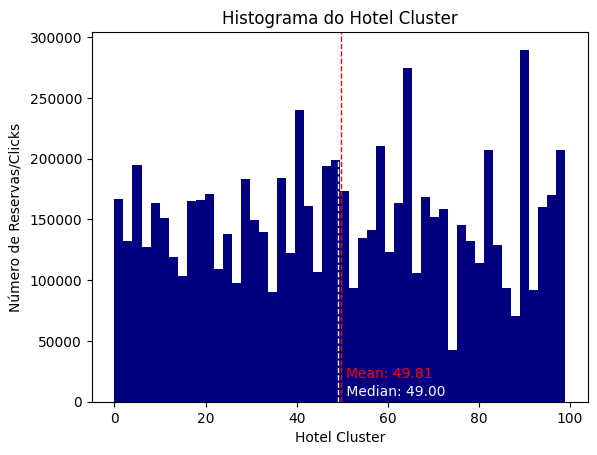

In [45]:
# Selecionar os dados a representar e converter para um dataframe em Pandas 
df_hist = df_expedia.sample(fraction=0.2, seed=123) \
                    .select('hotel_cluster').toPandas() # 20% dos dados - ~7M

# Representar o Histograma
plt.hist(df_hist['hotel_cluster'], bins=50, color= '#000080')

# Definir os rótulos dos eixos x e y
plt.xlabel('Hotel Cluster')
plt.ylabel('Número de Reservas/Clicks')

# Definir o Título do Gráfico 
plt.title('Histograma do Hotel Cluster')

# Adicionar linhas verticais e textos respetivos do valor da Média e da Mediana
plt.axvline(df_hist['hotel_cluster'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(df_hist['hotel_cluster'].median(), color='#f8f8ff', linestyle='dashed', linewidth=1)
plt.text(df_hist['hotel_cluster'].mean()+1, 20000, 'Mean: {:.2f}'.format(df_hist['hotel_cluster'].mean()), color='red')
plt.text(df_hist['hotel_cluster'].median()+1, 5000, ' Median: {:.2f}'.format(df_hist['hotel_cluster'].median()), color='#f8f8ff')
plt.show()

> Verifica-se uma **distribuição homogénea** da variável target `hotel_cluster`, sendo a Média e Mediana aproximadamente iguais.

### Gráfico de Barras

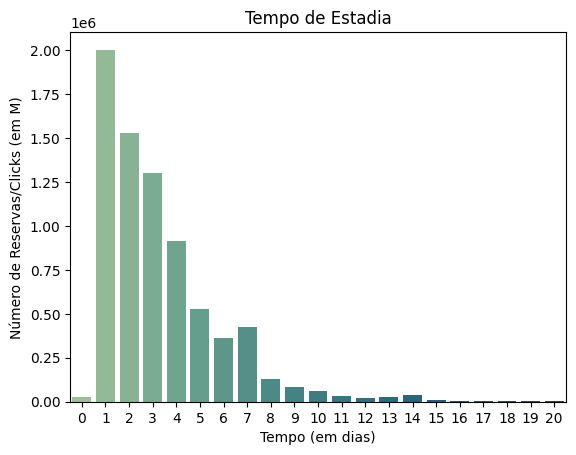

In [46]:
# Filtrar por Tempo de Estadia máximo de 20 dias (20% dos dados)
df_plot = df_expedia.sample(fraction=0.2, seed=123) \
                    .groupby('tempo_estadia') \
                    .count() \
                    .sort('tempo_estadia', ascending=True) \
                    .where((df_expedia.tempo_estadia >=0) & (df_expedia.tempo_estadia <= 20)).toPandas()

# Representar do Gráfico de Barras
sns.barplot(data=df_plot, x='tempo_estadia', y='count', hue=None, palette='crest')
            
# Definir os rótulos dos eixos x e y
plt.xlabel('Tempo (em dias)')
plt.ylabel('Número de Reservas/Clicks (em M)')

# Definir o Título do Gráfico 
plt.title('Tempo de Estadia')
plt.show();

> É possível notar que o **Tempo de Estadia** mais procurado é os com a menor duração, excepto os que fazem ***Check-In*** e ***Check-Out*** no próprio dia. 

### ScatterPlot

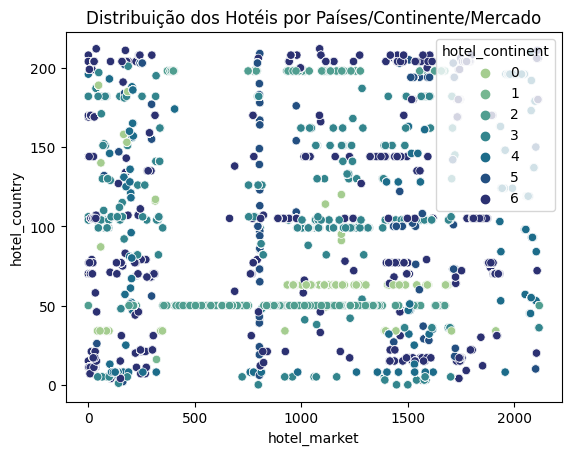

In [47]:
# Selecionar os dados a representar e converter para um dataframe em Pandas (10% dos dados)
df_plot1 = df_expedia.sample(fraction=0.1, seed=123) \
                     .select("hotel_continent", "hotel_country", "hotel_market").toPandas()

# Representar o ScatterPlot
sns.scatterplot(x= 'hotel_market', y='hotel_country', hue='hotel_continent', data=df_plot1, palette='crest', legend='full')
plt.title('Distribuição dos Hotéis por Países/Continente/Mercado')
plt.show()

> Observa-se que entre o `Hotel_Market` $400$ e $600$ não se apresentam hotéis (como se pode notar pelo espaço vazio nessa área), o que demonstra que os mercados entre estes valores são nichos, situando-se sobretudo pelo país representado pelo $50$.  

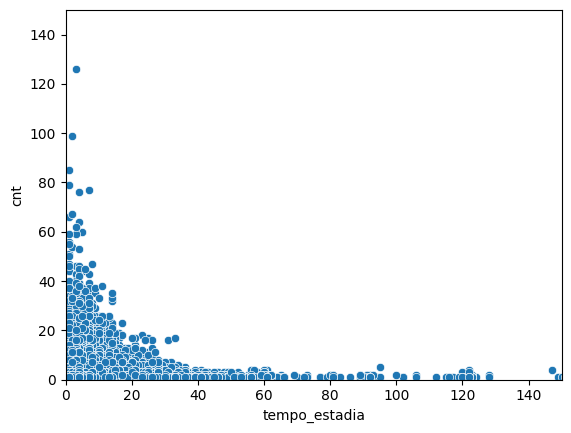

In [48]:
# Selecionar os dados a representar e converter para um dataframe em Pandas (10% dos dados)
df_plot2 = df_expedia.sample(fraction=0.1, seed=123) \
                      .select(F.col("cnt"), F.col("tempo_estadia")).toPandas()

# Representar o ScatterPlot
sns.scatterplot(x='tempo_estadia', y='cnt', data=df_plot2, palette='crest')
plt.xlim(0,150) # Para melhor visualização fizemos o gráfico com limite de x e y 150
plt.ylim(0,150)
plt.show()

> Com base na análise do **ScatterPlot**, podemos inferir que a maioria dos *users* prefere pesquisar hotéis por um curto período de tempo em vez de estadias mais longas.

### BoxPlot

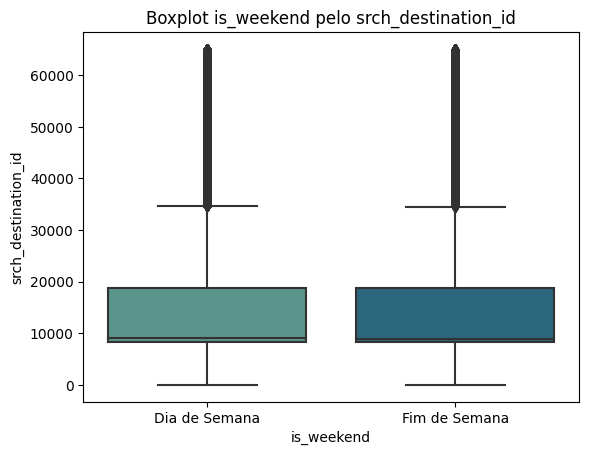

In [49]:
# Converter a variável date_time_diasemana em categórica indicando se é ou não fim de semana (20%)
df_plot3 = df_expedia.sample(fraction=0.2, seed=123) \
                     .withColumn("is_weekend", 
                                 F.when((df_expedia.date_time_diasemana == 1) | (df_expedia.date_time_diasemana == 7), "Fim de Semana") \
                                 .otherwise("Dia de Semana")) \
                     .select("srch_destination_id", "is_weekend").toPandas().astype({'srch_destination_id': 'int', 'is_weekend':'category'})

# Representação do Boxplot
sns.boxplot(x="is_weekend", y="srch_destination_id", data=df_plot3, palette='crest')
plt.title('Boxplot is_weekend pelo srch_destination_id')
plt.show()

> Sejam procuras durante a semana ou ao fim de semana, a maior concentração de destinos é entre o id $90000$ e $180000$.

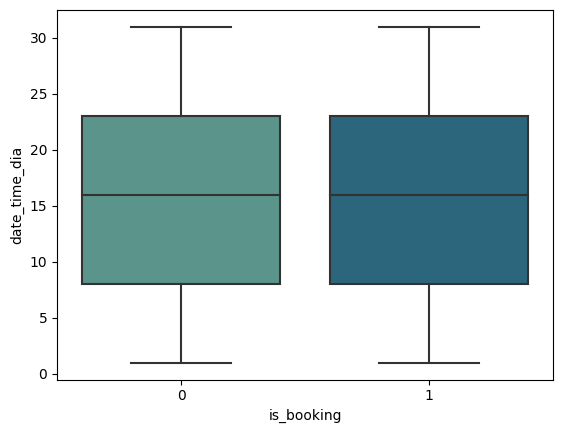

In [50]:
# Selecionar os dados a representar e converter para um dataframe em Pandas (20% dos dados)
df_plot4 = df_expedia.sample(fraction=0.2, seed=123) \
                     .select("date_time_dia", "is_booking").toPandas()

# Representação do Boxplot
sns.boxplot(x="is_booking", y="date_time_dia", data=df_plot4, palette='crest')
plt.show()

> Sejam reservas ou apenas cliques, a dispersão é semelhante nos dias dos meses.

### Série Temporal

In [51]:
# Converter a coluna srch_ci em formato de data
date_bookings_clicks = df_expedia.withColumn("Date", F.to_date("srch_ci", "yyyy-MM-dd"))

# Contar as observações por classes (Contagem dos 0 e 1 do is_booking agrupados por data)
date_bookings_clicks = date_bookings_clicks.groupby("Date") \
                                           .agg(F.count("is_booking").alias("Clicks"), 
                                                F.sum("is_booking").alias("Bookings")) \
                                           .withColumn("Clicks", F.col("Clicks") - F.col("Bookings")).toPandas().set_index("Date")

# Converter o índice para o formato datetime e definir a unidade de tempo para mês
date_bookings_clicks.index = pd.to_datetime(date_bookings_clicks.index)
date_bookings_clicks_monthly = date_bookings_clicks.resample('M').sum()

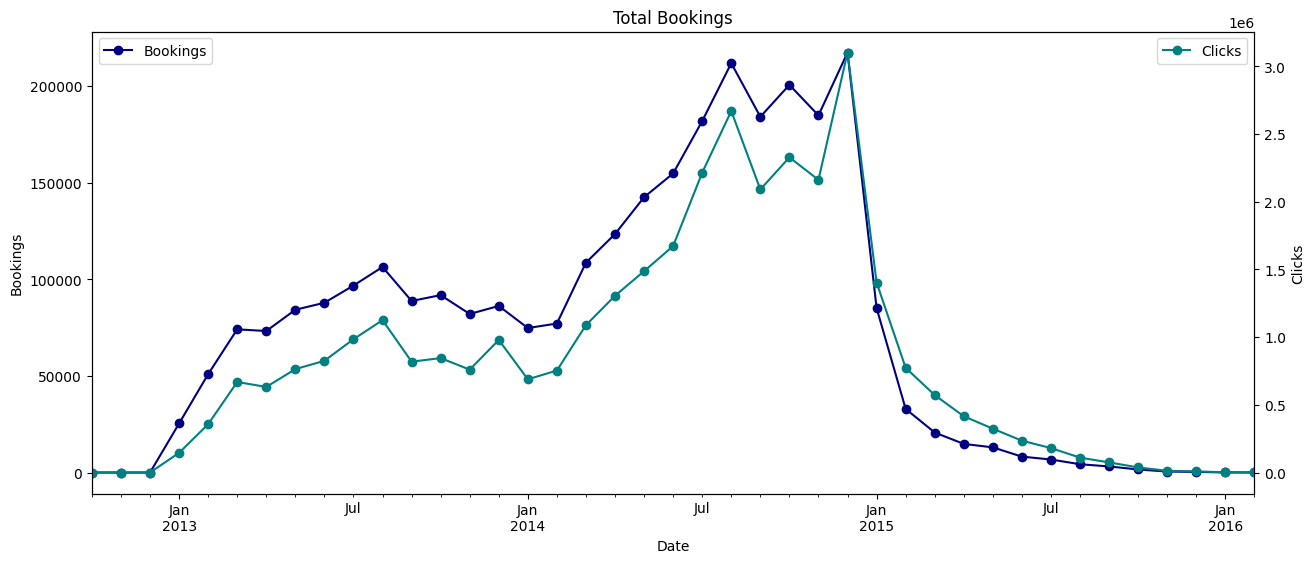

In [52]:
# Representação Gráfica da Série Temporal
fig, ax1 = plt.subplots(figsize=(15,6))

# Definir o Título do Gráfico e os rótulos dos eixos x e y
ax1.set_title("Total Bookings")
ax1.set_ylabel("Bookings")
ax2 = ax1.twinx()
ax2.set_ylabel("Clicks")

# Representar as linhas temporais
date_bookings_clicks_monthly["Bookings"].plot(legend=True, marker='o', color='#000080', ax=ax1)
date_bookings_clicks_monthly["Clicks"].plot(legend=True, marker='o', color='#008080', ax=ax2)

# Definir as Legendas
ax1.legend(["Bookings"],loc="upper left")
ax2.legend(["Clicks"])
ax1.set_xlim(pd.Timestamp("2012-10-31"), pd.Timestamp("2016-02-28"))
ax1.xaxis
plt.show()

> Apesar de serem em unidades diferentes, tanto as *Reservas* como os *Clicks* seguem uma mesma tendência na Série Temporal, verificando-se uma elevada procura na época sazonal de **Verão** e meses subsequentes até à **Época Natalícia**.

---

# 💾 Guardar os dados

In [90]:
# Confirmar o nº de observações e tipos de dados
print(df_expedia.count())
df_expedia.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

37622378
root
 |-- srch_destination_id: integer (nullable = true)
 |-- date_time: string (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- orig_destination_distance: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- is_mobile: integer (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 |-- hotel_country: 

In [91]:
# Guardar o dataset com as variáveis transformadas/adicionadas
df_expedia.write.mode("overwrite").parquet("df-expedia-2")
# df_expedia.write.mode("overwrite").parquet("s3://pdb-grupo17-bucket-as/df-expedia-2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---

# 🔗 Referencias Bibliográficas

**[1]** Apache Spark. (n.d.-c). pyspark.sql.functions.dayofweek — PySpark 3.3.2 documentation. Spark.apache.org. https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.dayofweek.html

**[2]** Rahal, A. (2019, April 5). scala - Failed to execute user defined function(VectorAssembler. Stack Overflow. https://stackoverflow.com/questions/55536970/failed-to-execute-user-defined-functionvectorassembler